# CS166 Grocery Store Queues
### Ang Li-Lian

# Project Brief

Determine how many cashiers a grocery store should employ given the following constraints:

- Maximum of 10 cashiers can be employed 
- Cashier only serves one customer at a time in a regular queue
- Opening time is 9am
- Closing time is 6pm (no additional customers will be served, but customer already in line will be)
- There is only one manager employed at all times

The grocery store has given us the following observations about how their grocery store operates:

- Arrival rate of customers (exponentially distributed) : $\lambda$ = 1 customer/min
- Cashier service (normally distributed): $\tau$ = 3 mins, $\sigma_1$ = 1 min
- Manager service (normally distributed): $\mu$ = 4 mins, $\sigma_2$ = 1 min
- Chance for requesting extended service: 0.05


# Classic Queueing Model - A Theoretical Approach
With the given information, it is possible to partially determine how many cashiers the grocery store should employ based on calculation alone. The type of queue that is being described is an M/G/1 queue, where M represents an exponential arrival distribution, G a general service distribution and 1 for the number of queues. It assumes that after one customer is served, the next immediately starts. There is no limit to the length of these queues, so technically within the theoretical model they could go on forever.

The following cell describes the equations that are used to output the average queue length and the average waiting time per customer at equilibrium. With the assumption that the queues have been running for a long time and have achieved a stable state, past the initialisation. Since the arrival rate we have been given is not an arrival rate for each queue, but for the store in its entirety, for the sake of simplicity, let us assume that the customers randomly select which queue they will join. Therefore, we can divide our arrival rate by the number of queues to determine the mean arrival rate per queue. We are essentially modelling the same number of M/G/1 queues as there are cashiers.

- Average waiting at equilibrium = $ \frac{\rho \tau}{2(1-\rho)} \left(1+\frac{\sigma^2}{\tau^2}\right)$
- Average queue length at equilibrium = $\frac{\rho^2}{2(1-\rho)} \left(1+\frac{\sigma^2}{\tau^2}\right)$
- Utilisation $\rho$ = $\lambda \tau$

In [1]:
tau = 3 # mean service time
sigma = 1 # variance service time
lam = 1 # mean arrival rate

def theoretical_queue(rho):
    return rho**2 / 2 / (1-rho) * (1 + sigma**2 / tau**2)

def theoretical_wait(rho):
    return (rho*tau)/(2*(1-rho)) * (1+ sigma**2 / tau**2)

Text(0.5, 1.0, 'Theoretical Average Queue Length')

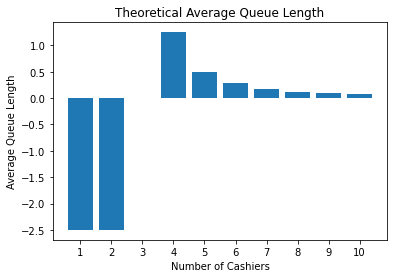

In [2]:
import matplotlib.pyplot as plt

queue = [theoretical_queue(tau* lam/num_cashiers) for num_cashiers in [1,2,4,5,6,7,8,9,10]]

plt.bar([1,2,4,5,6,7,8,9,10], queue)
plt.locator_params(axis='x', nbins=11)
plt.xlabel("Number of Cashiers")
plt.ylabel("Average Queue Length")
plt.title("Theoretical Average Queue Length")

Figure 1. Average queue length at equilibrium as described by an M/G/1 model with between 1-10 cashiers.

Text(0.5, 1.0, 'Theoretical Average Wait Time')

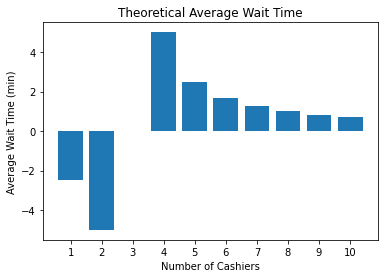

In [3]:
wait = [theoretical_wait(tau/num_cashiers) for num_cashiers in [1,2,4,5,6,7,8,9,10]]

plt.bar([1,2,4,5,6,7,8,9,10], wait)
plt.locator_params(axis='x', nbins=11)
plt.xlabel("Number of Cashiers")
plt.ylabel("Average Wait Time (min)")
plt.title("Theoretical Average Wait Time")

Figure 2. Average waiting time (min) per customer at equilibrium as described by an M/G/1 theoretical model with between 1-10 cashiers

In theoretical models, the utilisation is $\rho <1$ to prevent the queue from growing uninhibited. Since utilisation describes the ratio of customer arrival to customer serivce, a utilisation of more than 1 would mean that the queue can grow infinitely long. We can see the effects in Figure 1 and 2. 

Within this model the utilisation can be simplified to be the ratio of the average service time to the number of cashiers ($\tau:cashiers$). When the number of cashiers is less than three, model outputs an invalid figure for the average queue length and average wait time since both these values cannot realistically take on a negative number. At exactly 3 cashiers, the model returns an undefined value since within the equation it would be dividing by zero. It also means practically that we are unable to mathematically calculate what those values are.

With more than 3 cashiers, we see an exponentially shaped graph that could be insightful. It shows a general trend that having more cashiers reduces both the average wait time and the average queue length. But it is unable to take into account the presence of the manager in the grocery store or the constraints of the grocery store's operating hours. With this much gap in information, we will turn to creating a simulation of the grocery store in an effort to overcome the limitations of a theoretical model.

# A Simulation Approach

In the following simulation, we will attempt to recreate the grocery store's operation using code. There will be many elements that continue to be simplified as in the theoretical approach such as customer behaviour, cashier efficiency and the assumption that nothing out of the norm happens. There are several advantages to exploring the main question using a simulation instead of jumping straight into a real life experiment:

- Relatively cost free

Aside from the time needed to code the simulation (and perhaps to pay for someone to code it for you), there would be relatively no cost invoivled compared to that in the process of hiring, firing and training employees.

- A more ethical solution

Along with the financial burden, there are also moral reasons. Experimenting with real people's lives and job security for the sake of experimentation is frowned upon within the scientific community and humanitarian laws, even at the commercial level. In seeking answers to questions, you should not sacrifice the well-being of others to achieve that end, especially when there are other means readily available.

- Independence

In a simulation, every experiment will be independent of each other since we have defined each simulation to be so. However, in real life, it is more difficult to control for how each simulation will impact each other. If say, you started off the experiment with only one cashier and the queue extends out the store and down the street, it may affect the following experiments because customers are turned off from shopping at your grocery store. This would change the arrival rate, making one experiment incomparable to the next.

- Controlling for confounding variables and creating a constant environment

In real life, we cannot predict how things may change from day to day. What if one of your cashiers is especially sleep-deprived on the job? What if the cashier machines start malfunctioning? What if the grocery store further down the street is giving away free ice-cream on a particular day? All these factors and more could change the metrics you would calculate. It is nearly impossible to control for them, and therefore will not give robust results that can be compared to each other with confidence for decision making.

All that being said, there are also limitations to performing simulations. For one thing, this is a _simulation_. At the end of the day, we are feeding the model with assumptions about how we believe the real world operates. It will always be just an approximation at best since, by being an abstraction, it cannot fully account for the complexities of the real world. However, it is a good starting point where we can fine-tune parameters as necessary. All parameters we are including in the model are based on observational data about how the grocery store operates in reality, and can be tweaked depending on how that information changes.

## Basic Model
According to the model, the customers will arrive as depicted in the flow diagram until closing time at 6pm where the existing customers in the queue will finish being served. The customers will select which queue to line up in based on which is the shortest which models how real customers usually decide which queue to join. It is based off the perception that the shortest queue will finish the fastest.

<img src="arrival.png" alt="Customer Arrival Flow" width="500" align="center"/>

The service of each customer is depicted in the flow diagram below. If a customer calls the manager for extended service, the whole queue will have to wait for the manager to finish serving the customer with the assumption that the customer is calling for the manager because they are having trouble with their checkout that the cashier cannot or does not have the authority to solve.

<img src="service.png" alt="Customer Service Flow" width="500" align="center"/>

In [4]:

import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [5]:
import scipy.stats as sts
import numpy as np
import pandas as pd


class Customer:
    def __init__(self):
        self.start_wait = 0
        self.end_wait = 0
        self.num_items =round(np.random.uniform(low = 1, high = 30)) #for extended

class Queue:
    """
    Stores the customers in the queue, waiting times, queue length and total idle time
    of each cashier.
    """

    def __init__(self, manager, service_mean = None, service_sd =None):
        # Store the normally distributed service time for an M/G/1 queue
        self.service_distribution = sts.norm(loc = service_mean, scale = service_sd)
        
        # We start with an empty queue and the server not busy
        self.people_in_queue = []
        self.people_being_served = False
        self.manager = manager
        
        self.idle_time = 0
        self.idle_start = 0

        self.stats = pd.DataFrame({
            "waiting_times": [],
            "queue_length":[]
        })

    def add_customer(self, schedule, customer= None):
        # Add the customer to the queue
        try:
            customer.start_wait = schedule.now
            self.people_in_queue.append(customer)
        except:
            pass

        if self.people_being_served == False:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            self.idle_time += (schedule.now - self.idle_start)

    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_being_served = True

        self.people_in_queue[0].end_wait = schedule.now 

        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.ask_manager)

    def ask_manager(self,schedule):
        # 5% chance of requiring extended service
        if np.random.random() < 0.05:
            schedule.add_event_after(0, self.manager.add_customer, self)
        else:
            schedule.add_event_after(0, self.finish_serving_customer)

    def finish_serving_customer(self, schedule):
        # Remove the customer from the cashier
        customer = self.people_in_queue.pop(0)
        self.people_being_served = False

        # Store the statistics about the customer wait time and queue length
        self.stats = self.stats.append(
            {"waiting_times":(customer.end_wait- customer.start_wait),
            "queue_length":(len(self.people_in_queue))}
            , ignore_index =True)

        if len(self.people_in_queue) > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)
        else:
            self.idle_start = schedule.now

class Manager():
    """
    Stores the queue sequence for the manager
    """
    def __init__(self):
        self.mean = 4
        self.sd = 1
        self.service_distribution = sts.norm(loc =self.mean, scale = self.sd)

        self.people_being_served = False
        self.people_in_queue = []
    
    def add_customer(self, schedule,queue_id):
        # Add the customer to the queue
        self.people_in_queue.append(queue_id)

        if self.people_being_served ==False:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
    
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_being_served= True
        
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_customer)
    
    def finish_serving_customer(self, schedule):
        # Remove the customer from the manager
        self.people_being_served = False
        queue = self.people_in_queue.pop(0)

        # Allow the cashier to start serving again
        schedule.add_event_after(0, queue.finish_serving_customer)
        
        if len(self.people_in_queue) > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)

class GroceryStore:
    """
    Stores the cashiers and managers. Controls the in flow of customers.
    """
    def __init__(self, run_until, num_cashier):
        self.manager = Manager()

        self.service_mean = 3
        self.service_sd = 1
        self.queue=[Queue(self.manager,self.service_mean,self.service_sd) 
                        for x in range(num_cashier)]

        self.arrival_rate = 1
        self.arrival_distribution = sts.expon(scale=1/self.arrival_rate)

        self.run_until = run_until

    def add_customer(self, schedule):
        # Accept customers while the store is open
        if schedule.now< self.run_until:
            # Customer chooses the shortest queue
            index = min(range(len(self.queue)), 
                key=lambda i: len(self.queue[i].people_in_queue))
            self.queue[index].add_customer(schedule, Customer())
            
            # Schedule when to add another customer
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)
        
        # Finish queues when store is closed
        else:
            return

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def extract_stats(self):  
        # Returns relevant statistics about the queues    
        if len(self.queue)>1:  
            stats = pd.concat([queue.stats for queue in self.queue], axis =0)
            idle = [queue.idle_time for queue in self.queue]
        else:
            stats = self.queue[0].stats
            idle = self.queue[0].idle_time

        queue_stats = pd.DataFrame({
            "mean_wait": [np.mean(stats["waiting_times"])], 
            "mean_idle": [np.mean(idle)], 
            "max_queue": [stats["queue_length"].max()]
        })

        return queue_stats

In [6]:
def run_simulation(num_cashier):
    schedule = Schedule()
    run_until = 540 # Grocery store open from 9am to 6pm
    grocery_store = GroceryStore(run_until, num_cashier)
    grocery_store.run(schedule)
    
    # Stops adding more customers at closing
    while len(schedule.priority_queue)>0: 
        schedule.run_next_event()    
    
    return grocery_store.extract_stats()

## The Metrics 
There are three metrics we will be extracting from the model to determine how many cashiers the grocery store should hire:

1. Average customer waiting time
2. Average maximum queue length
3. Average cashier idle time 

Note that here we are defining customer wait time from the time they begin queuing until they start being served.

We are taking the average because we are assuming that each customer and cashier is identical to each other, therefore an average figure would suffice. For each of the 100 trials we will be conducting on each number of cashiers, we will store these metrics and calculate a 95% confidence interval. The size of this interval will tell us the range we can expect the actual average value to fall within.

The cashier idle time will be helpful during our analysis to determine how much active work cashiers are doing as oppose to waiting for customers to arrive. This metric is helpful because obviously having the maximum number of cashiers will reduce waiting time and queue length. Knowing how much work each cashier is doing will give us a sense of at which point we are getting diminishing returns.

In [7]:
def experiment():
    """
    Runs simulation over set number of trials for each number of cashiers

    Returns:
        simulations (dataframe)

    """
    simulations = pd.DataFrame({
        "num_cashiers": [],
        "wait_ev": [],
        "wait_conf":[],
        "idle_ev":[],
        "idle_conf":[],
        "queue_ev":[],
        "queue_conf":[]
    })
    
    for num_cashier in range(1,11): # Simulate with 1-10 cashiers
        plot_x = pd.DataFrame({
            "mean_wait":[], 
            "mean_idle":[], 
            "max_queue":[]})

        for i in range(100): # Number of trials per simulation
            plot_x = pd.concat([plot_x, run_simulation(num_cashier)], axis =0)

        simulations = simulations.append({
            "num_cashiers": int(num_cashier),
            "wait_ev": np.mean(plot_x["mean_wait"]),
            "wait_conf":1.96*sts.sem(plot_x["mean_wait"]),
            "idle_ev":np.mean(plot_x["mean_idle"])/60,
            "idle_conf":1.96*sts.sem(plot_x["mean_idle"])/60,
            "queue_ev":np.mean(plot_x["max_queue"]),
            "queue_conf":1.96*sts.sem(plot_x["max_queue"])
        }, ignore_index = True)
    
    return simulations

In [8]:
exp = experiment()
exp

,num_cashiers,wait_ev,wait_conf,idle_ev,idle_conf,queue_ev,queue_conf
0,1.0,593.979281,6.846111,0.016890,0.003726,371.23,3.969074
1,2.0,166.526664,3.987717,0.036006,0.005173,104.10,2.215474
2,3.0,25.934901,2.332550,0.173654,0.031745,16.76,1.142228
3,4.0,1.873576,0.124686,1.745017,0.072803,3.39,0.157331
4,5.0,0.525710,0.035147,3.240426,0.050269,1.82,0.122639
5,6.0,0.195088,0.015294,4.135764,0.048332,1.12,0.064013
6,7.0,0.074389,0.007118,4.779579,0.038789,1.01,0.019600
7,8.0,0.025892,0.003701,5.177560,0.041974,0.98,0.027578
8,9.0,0.008829,0.002076,5.425605,0.055063,0.72,0.088447
9,10.0,0.002774,0.001237,5.299335,0.092219,0.43,0.097524


In [9]:
import seaborn as sns

def summary_plot(exp, lower_lim):
    sns.set()
    fig, axes = plt.subplots(1,3, sharex = True, figsize = (20,5))
    fig.suptitle("Basic Model Summary")
    num_cashiers = [x for x in range(10-lower_lim)]

    # Average Waiting Time
    sns.barplot(ax = axes[0], data = exp[exp["num_cashiers"]>lower_lim], 
            x ="num_cashiers", y ="wait_ev", color = "salmon")
    axes[0].set_title("Average Customer Wait Time")
    axes[0].set(xlabel ="Number of Cashiers", ylabel ="Average wait time (min)")
    axes[0].errorbar(data = exp[exp["num_cashiers"]>lower_lim], x= num_cashiers,y= "wait_ev",
                yerr="wait_conf", fmt='none', c= 'black', capsize = 5)

    # Average Idle Time
    sns.barplot(ax = axes[1], data = exp[exp["num_cashiers"]>lower_lim], 
            x ="num_cashiers", y ="idle_ev", color = "salmon")
    axes[1].set_title("Average Cashier Idle Time")
    axes[1].set(xlabel ="Number of Cashiers", ylabel ="Average idle time (hours)")
    axes[1].errorbar(data = exp[exp["num_cashiers"]>lower_lim], x=num_cashiers ,y= "idle_ev",
                yerr="idle_conf", fmt='none', c= 'black', capsize = 5)

    # Average Max Queue Length
    sns.barplot(ax = axes[2], data = exp[exp["num_cashiers"]>lower_lim], 
            x ="num_cashiers", y ="queue_ev", color = "salmon")
    axes[2].set_title("Average Maximum Queue Length")
    axes[2].set(xlabel ="Number of Cashiers", ylabel ="Average max queue length")
    axes[2].errorbar(data = exp[exp["num_cashiers"]>lower_lim], x=num_cashiers,y= "queue_ev",
                yerr="queue_conf", fmt='none', c= 'black', capsize = 5)

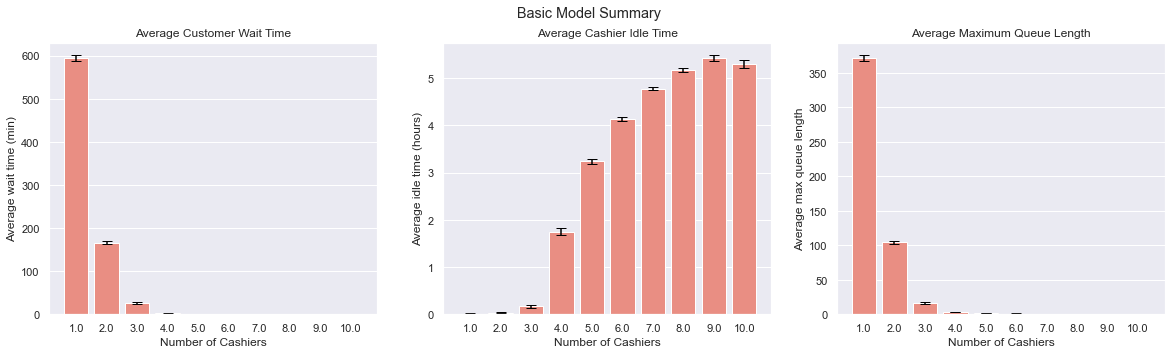

In [10]:
summary_plot(exp, 0)

Figure 3. Error plot of the basic grocery model with average customer wait time, average cashier idle time and average maximum queue length (from left to right) for having 1-10 cashiers in the 95% confidence interval.

The error bar shows the 95% confidence interval of these mean values. The bar is wider for number of cashiers at 3 than it is for higher numbers of cashiers in wait time and queue length which shows the range of values we can expect the actual value to be within. With having more cashiers, that range, decreases meaning that we have more certainty of exactly where the actual value will be. The error bar barely exceeds the expected value by even one unit,thereby making our results for number of cashiers more than 3 more robust, especially with the number of trials we have done.

As shown in Figure 3, when the number cashiers is less than three, the average waiting time and average maximum queue length grows to a very large number which is unfeasible for a grocery store. As shown in Figure 4 when we zoom in on the relevant values, even with three cashiers, the waiting times are over half an hour and the queue length longer than 20 people. 

Customers will certainly be turned off by such an experience which means that at the bare minimum to maintain customers a grocery store should employ 4 cashiers, but is that really the case?

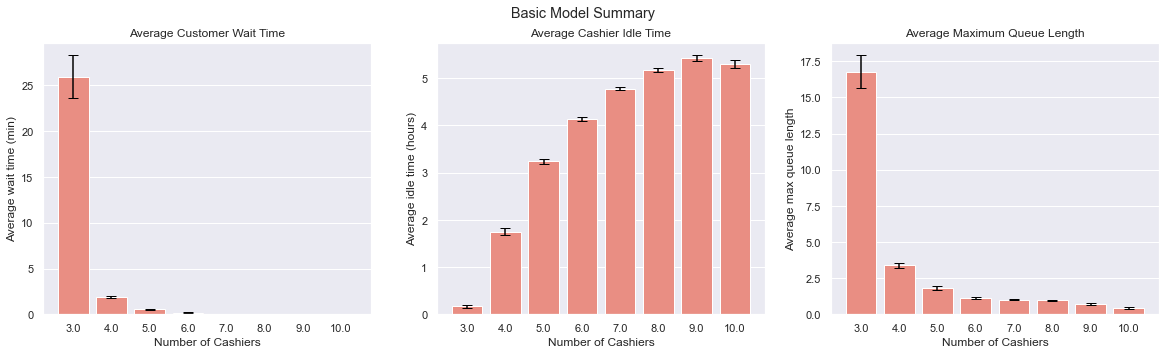

In [11]:
summary_plot(exp, 2)

Figure 4. Error plot of the basic grocery model with average customer wait time, average cashier idle time and average maximum queue length (from left to right) for having 3-10 cashiers in the 95% confidence interval.

### Solution #1: Employ 4 Cashiers

Looking purely at the average waiting time and average queue length in Figure 4, it seems obvious that the grocery store should employ 4 people at minimum, but there is a fair jump in idle time for each cashiers between employing 3 and 4 cashiers. That number only grows hourly with each additional cashier employed. From an efficiency standpoint, it means that the grocery store will be paying cashiers for almost two or more hours of just standing around. At the extreme of having ten cashiers employed, each cashier will have idle time that amounts to the half the entire operating hours of the grocery store!

However, as inclined as one might feel to milking each employee for every minute they are being paid for, we have to take into consideration that each cashier requires work breaks. They aren't robots who can continuously serve customers for nine hours straight. It will wear out the cashiers and cause them to quit, giving additional costs to employ and train another cashier. But more importantly, it is against the worker's rights to be denied a break.

The almost 2 hour idle time seen in Figure 4 for having four cashiers can't be considered an alloted break time because what this model shows is what happens when there are a set number of cashiers working simultaneously. Their cumulative idle time may be about 2 hours, but these may come in minute chunks between one customer finished serving and the next customer arriving. During this time, the cashier may not be working in terms of checking out a customer, but they are still on duty. If the cashier were to go on break, the total number of cashiers would drop to 3 which allows for the queue length and average wait time to grow to the values we are seeing in Figure 4.

Lunch breaks as mandated by most labour laws are at minimum thirty minutes and between shift breaks are usually about 10 minutes every couple of hours for long shifts such as that in the grocery store. During the half an hour or ten minutes that the number of cashiers drops from 4 to 3, the queue length and wait time will only suffer for that short period of time which is feasible for a customer, especially when in reality there are high and low period of customer arrival that the grocery store can take into account when scheduling breaks.

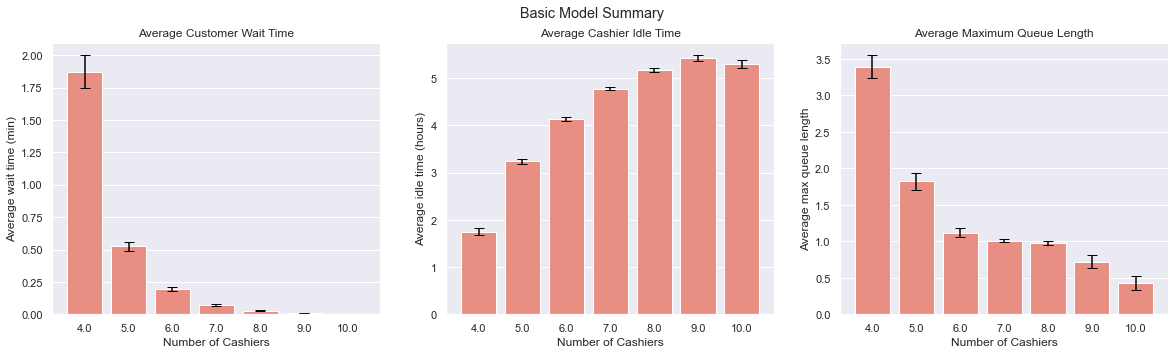

In [12]:
summary_plot(exp,3)

Figure 5. Error plot of the basic grocery model with average customer wait time, average cashier idle time and average maximum queue length (from left to right) for having 4-10 cashiers in the 95% confidence interval.

### Solution #2: Employ 5 cashiers

The decision also depends on the culture of the grocery store. If one of the subgoals is to increase employee satisfaction and subsequently employee retention, the grocery store might consider allowing employees to take breaks in pairs where they might have a chance to get to know each other and foster better relationships. This could in turn increase their productivity in the long run, making them more efficient and happy.

In this case, looking at Figure 5, the average wait time would drop by a fairly insignificant amount (about 1 minute), but the queue length would drop by about 2. Visually looking at the queues, customers would not perceive a long wait in addition to actually not waiting for long. The biggest setback is the idle time for each cashier which at maximum would be more than half of their total shift.

# How many cashiers should the grocery store employ?

Compared to the previous theoretical model, the simulation has a shorter average wait time and longer average maximum queue length. These differences can be attributed to the fact that the simulation takes into account two major features that the theoretical model doesn't.

1. Customers choose the shortest queue and not a random one
2. There are manangers in the simulation

The first changes how long each individual customer has to wait since they are making 'smarter' decisions that minimise their wait time, the effects of that decision is reflected in the results. The second works against the first to conversely increase wait time and queue length, by allowing one queue to grow while waiting for a customer to be served by a manager. The general trends of both models are the same, with increasing change in time/length as the number of cashiers increase. It would have been difficult to incorporate the two features into a theoretical model which serves to highlight the benefits of performing a simulation which has given more specific data and allowed us to calculate the third metric of average cashier idle time, allowing us to come to the following conclusion.

The current model is a simplified version of what real-life operations might look like, so the results are dependent on the initial assumptions we have fed into it. However, one thing that the model does show for certain is that having three or fewer cashiers will increase wait time and queue length to an unfeasible amount, while having 6 or more cashiers employed will drastically reduce the prodcutivity of each cashier.

Therefore, it really is a choice between 4 or 5 cashiers depending on the grocery store budget, the cashier wages, number of days worked a week, structure of shifts or days of grocery store operation in a week. These are all factors to take into account when fine-tuning the number of cashiers to ultimately employ.


# Extension Model - Express Lanes

<img src="express.png" alt="Grocery store with express and regular lanes" width="500" align="center"/>


Another possible way to model the grocery store could be to introduce an express lane where customers who buy ten items or less can queue separately in a single queue. The following flow diagram shows how customer arrivals would then be handled. The service of each customer is handled in exactly the same way, the major difference is how the queues work in the express lane and that the sevice distribution now takes into account the number of items bought by the customer.

- Cashier service (normal distribution): $\mu = 1+0.1n$ min, $\sigma = 0.5$min
- Number of items (uniform distribution): 1 to 30 items



<img src="extended_arrival.png" alt="Customer Service Flow with Express Lane" width="500" align="center"/>

In [13]:
class Express:
    """ 
    Stores all the queues in the express lane.
    """
    def __init__(self, num_cashier, manager):
        self.people_in_queue = []
        self.cashier = [ExpressQueue(manager, self) for x in range(num_cashier)]
        self.stats = pd.DataFrame({
            "waiting_times": [],
            "queue_length":[]
        })

    def add_customer(self, schedule, customer=None):
        # Add the customer to the queue
        try:
            customer.start_wait = schedule.now
            self.people_in_queue.append(customer)
        except:
            pass

        schedule.add_event_after(0, self.start_serving_customer)

    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        customer = self.people_in_queue.pop(0)

        index = min(range(len(self.cashier)), 
            key=lambda i: self.cashier[i].people_being_served)

        if self.cashier[index].people_being_served ==False:
            # This customer can be served immediately
            schedule.add_event_after(0, self.cashier[index].add_customer, customer)

    def finish_serving_customer(self, schedule, customer):
        self.stats = self.stats.append(
            {"waiting_times":(customer.end_wait- customer.start_wait),
            "queue_length":(len(self.people_in_queue))}
            , ignore_index =True)
        
        if len(self.people_in_queue) > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)

class QueueExtended(Queue):
    """
    Stores queue length, customer wait time and idle time for regular queue
    """
    def __init__(self, manager):
        super().__init__(manager)
        self.sd = 0.5
    
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_being_served = True
        self.people_in_queue[0].end_wait = schedule.now

        # Customer service time
        service_mean = 1+ self.people_in_queue[0].num_items*0.1
        service_distribution = sts.norm(loc =service_mean, scale = self.sd)

        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            service_distribution.rvs(),
            self.ask_manager)

class ExpressQueue(QueueExtended):
    """
    Stores queue length, customer wait time and idle time for express queue
    """
    def __init__(self,manager,express):
        super().__init__(manager)
        self.express = express

    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        customer = self.people_in_queue.pop(0)

        self.people_being_served = False
        
        schedule.add_event_after(0, self.express.finish_serving_customer, customer)

        self.idle_start = schedule.now


class GroceryStoreExtended:
    """
    Stores all express and regular queues, and the manager's queue.
    """
    def __init__(self, run_until, num_cashier):
        self.manager = Manager()

        self.arrival_rate = 1
        self.arrival_distribution = sts.expon(scale=1/self.arrival_rate)

        self.queue = [QueueExtended(self.manager) for x in range(num_cashier[0])]
        self.express_queue = Express(num_cashier[1], self.manager)

        self.num_cashier = num_cashier
        self.run_until = run_until
    
    def add_customer(self, schedule):
        # Customers arrive until closing time
        if schedule.now < self.run_until:
            # Create a customer
            customer = Customer()

            # Check if customer goes to express lane
            if customer.num_items <= 10 and self.num_cashier[1]>0:
                self.express_queue.add_customer(schedule, customer)
            else:
                index = min(range(len(self.queue)), 
                    key=lambda i: len(self.queue[i].people_in_queue))
                self.queue[index].add_customer(schedule, customer)
            
            # Schedule when to add another customer
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)
        else:
            return


    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
    
    def extract_stats(self):     
        if len(self.queue)>1:  
            stats = pd.concat([queue.stats for queue in self.queue], axis =0)
            idle = [queue.idle_time for queue in self.queue]
        else:
            stats = self.queue[0].stats
            idle = self.queue[0].idle_time
        
        if self.num_cashier[1]>0:
                stats = pd.concat([stats, self.express_queue.stats], axis =0)
                idle += [queue.idle_time for queue in self.express_queue.cashier]
        
        queue_stats = pd.DataFrame({
            "mean_wait": [np.mean(stats["waiting_times"])], 
            "mean_idle": [np.mean(idle)], 
            "max_queue": [stats["queue_length"].max()]
        })
        return queue_stats
    

In [14]:
def run_simulation_extended(num_cashier):
    schedule = Schedule()
    run_until = 540 # Grocery store open from 9am to 6pm
    grocery_store = GroceryStoreExtended(run_until, num_cashier)
    grocery_store.run(schedule)
    
    while len(schedule.priority_queue) > 0: #stops adding more customers
        schedule.run_next_event()    
    
    return grocery_store.extract_stats()

In [15]:
def experiment_extended():
    simulations = pd.DataFrame({
        "num_cashiers": [],
        "num_express":[],
        "wait_ev": [],
        "wait_conf":[],
        "idle_ev":[],
        "idle_conf":[],
        "queue_ev":[],
        "queue_conf":[]
    })
    
    for num_cashier in range(1,11): # Simulate with 1-10 cashiers
        for num_express in range(0, (11-num_cashier)):
            plot_x = pd.DataFrame({
                "mean_wait":[], 
                "mean_idle":[], 
                "max_queue":[]})

            for i in range(100): # Number of trials per simulation
                plot_x=pd.concat([plot_x,run_simulation_extended([num_cashier,num_express])],axis=0)

            simulations = simulations.append({
                "num_cashiers": int(num_cashier),
                "num_express": int(num_express),
                "wait_ev": np.mean(plot_x["mean_wait"]),
                "wait_conf":1.96*sts.sem(plot_x["mean_wait"]),
                "idle_ev":np.mean(plot_x["mean_idle"])/60,
                "idle_conf":1.96*sts.sem(plot_x["mean_idle"])/60,
                "queue_ev":np.mean(plot_x["max_queue"]),
                "queue_conf":1.96*sts.sem(plot_x["max_queue"])
            }, ignore_index = True)
    
    return simulations

In [16]:
exp_ext = experiment_extended()

As seen in the DataFrame below, the average wait time and queue length for having just one or two regular cashier is extremely high and not worth considering, so we will disregard its combinations in the following analysis.

In [17]:
exp_ext[exp_ext["num_cashiers"]<3]

,num_cashiers,num_express,wait_ev,wait_conf,idle_ev,idle_conf,queue_ev,queue_conf
0,1.0,0.0,788.192339,8.403391,0.018602,0.003134,575.65,5.324157
1,1.0,1.0,402.102265,6.757026,9.489673,0.066340,326.99,4.662280
2,1.0,2.0,365.081766,7.411641,10.968601,0.050922,325.56,5.335074
3,1.0,3.0,361.187898,7.370149,11.921797,0.058017,329.12,5.335216
4,1.0,4.0,358.393277,6.975330,11.718750,0.213063,329.87,5.363606
5,1.0,5.0,356.536151,6.232385,10.473970,0.283972,328.65,4.587767
6,1.0,6.0,359.370376,6.538495,9.040518,0.287809,329.44,4.634048
7,1.0,7.0,350.094931,6.359979,7.620097,0.254323,322.66,4.647836
8,1.0,8.0,358.804241,7.114903,6.638859,0.212739,329.04,5.155422
9,1.0,9.0,354.722271,6.985216,5.776181,0.182396,327.73,5.220862


Text(0.5, 1.0, 'Average Maximum Queue Length')

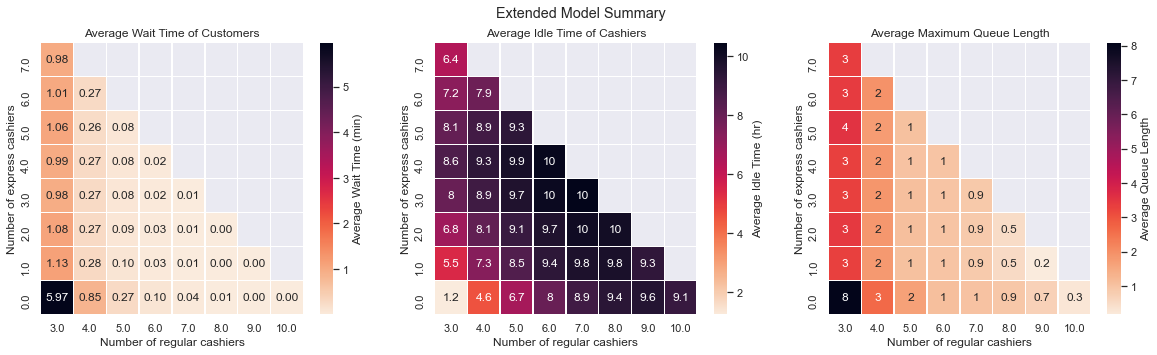

In [18]:
sns.set()
fig, axes = plt.subplots(1,3, figsize = (20,5))
fig.suptitle("Extended Model Summary")
num_cashiers = [x for x in range(1,10)]

# Heatmap for Average Wait Time
heatmap_wait = pd.pivot_table(
                    exp_ext[exp_ext["num_cashiers"]>2], 
                    values='wait_ev', 
                    index=['num_express'], 
                    columns='num_cashiers'
                    )
sns.heatmap(heatmap_wait, cbar_kws={'label': 'Average Wait Time (min)'},
        cmap= sns.cm.rocket_r, ax = axes[0], linewidths=.5, annot=True, fmt=".2f")
axes[0].invert_yaxis()
axes[0].set_xlabel("Number of regular cashiers")
axes[0].set_ylabel("Number of express cashiers")
axes[0].set_title("Average Wait Time of Customers")

# Heatmap for Average Idle Time
heatmap_idle = pd.pivot_table(
                    exp_ext[exp_ext["num_cashiers"]>2], 
                    values='idle_ev', 
                    index=['num_express'], 
                    columns='num_cashiers'
                    )
sns.heatmap(heatmap_idle, cbar_kws={'label': 'Average Idle Time (hr)'},
        cmap= sns.cm.rocket_r, ax = axes[1], linewidths=.5, annot=True, fmt=".2g")
axes[1].invert_yaxis()
axes[1].set_xlabel("Number of regular cashiers")
axes[1].set_ylabel("Number of express cashiers")
axes[1].set_title("Average Idle Time of Cashiers")

# Heatmap for Average Max Queue Length
heatmap_queue = pd.pivot_table(
                    exp_ext[exp_ext["num_cashiers"]>2], 
                    values='queue_ev', 
                    index=['num_express'], 
                    columns='num_cashiers'
                    )
sns.heatmap(heatmap_queue, cbar_kws={'label': 'Average Queue Length'},
        cmap= sns.cm.rocket_r, ax = axes[2], linewidths=.5, annot=True, fmt=".1g")
axes[2].invert_yaxis()
axes[2].set_xlabel("Number of regular cashiers")
axes[2].set_ylabel("Number of express cashiers")
axes[2].set_title("Average Maximum Queue Length")

Figure 6. Heatmaps of the extended model showing the average wait time, average idle time and average maximum queue length (left to right) for each permutation of regular and express cashiers. The minimum number of regular cashiers is 3 whereas the minimum for express cashiers is 0.

## How many regular and express cashiers should there be?

In this version of the model, having 3 cashiers provides a much different average wait time and average maximum queue length than the basic model. The service distribution is now dependent on the number of items each customer has and is normally distributed. This change in service times has also diminished the long waiting time and queue length for having only three regular cashiers as we saw in the basic model. 

Even though there are certainly gains to be made by adding express cashiers after having the minimum 3 regular cashiers, the gains are marginal. The average waiting decreases by by a fraction of a minute with the addition of the express lane. The maximum queue length does see gains by dropping by more than half its original maximum length, but those minimal gains are trumped by the increase in average cashier idle time. The average idle time more than doubles in the number of hours. At 3 regular cashiers and 1 express cashier, the idle time is more than half of the entire working period, making each employee quite inefficient.

With the given information, we can conclude that an express queue would not signficantly improve the grocery store's efficiency. The question now is how many regular cashiers we would employ given the new service distribution. Increasing the number of regular cashiers from 3 to 4 gives significant gains in average wait time and average maximum queue length with a slightly smaller increase in average idle time. If we take the cashier's break times and socialisation into consideration as we did in the basic model, we will reach a similar conclusion for the grocery store to choose to employ 3 or 4 cashiers depending on other factors.

However, the drastic change caused by changing the distribution for service time calls into question the efficacy of the results in our basic model. As an extension, closer observation of actual service distribution should be carried out within the grocery to more accurately determine how many cashiers should be employed.

